In [128]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, NMF
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [97]:
movie_df = pd.read_csv('movies.dat', sep = '::', header = None, names = ['movieId', 'Title', 'Genre'])
movie_df['Year'] = movie_df.Title.apply(lambda x:int(x.split('(')[-1].strip(')')))
movie_df['Title'] = movie_df.Title.apply(lambda x:x.split('(')[0].strip())
movie_df.head()

//anaconda/envs/cancer/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,movieId,Title,Genre,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


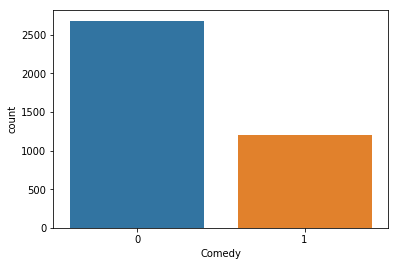

,movieId,Title,Year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',\
               'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    
def get_genre(string, genre):
    genre_list = string.split('|')
    if genre in genre_list:
        return 1
    else:
        return 0
        
for genre in genres:
    movie_df[genre] = movie_df['Genre'].apply(get_genre, genre = genre)
    
sns.countplot(movie_df.Comedy)
plt.show()     
movie_df = movie_df.drop(['Genre'], axis = 1)
movie_df.head()


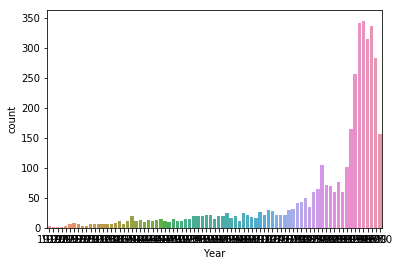

In [62]:
sns.countplot(movie_df.Year)
plt.show()

In [99]:
vectorizer = TfidfVectorizer(max_features = 100, stop_words='english')
vec = vectorizer.fit_transform(movie_df['Title'])
vec_df = pd.DataFrame(vec.toarray(), columns = vectorizer.get_feature_names())
movie_df = pd.concat([movie_df, vec_df], axis = 1).drop(['Title'], axis = 1)
movie_df
#print(vec_df.columns)

,movieId,Year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,trek,war,way,west,white,wild,woman,world,york,young
0,1,1995,0,0,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1995,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1995,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1995,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1995,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1995,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,1995,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,1995,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1995,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,1995,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
user_df = pd.read_csv('users.dat', sep = '::', header=None, names = ['userId', 'Gender', 'Age', 'Occupation', 'zipCode'])
user_df.head()

//anaconda/envs/cancer/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,userId,Gender,Age,Occupation,zipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [18]:
user_df.shape

(6040, 5)

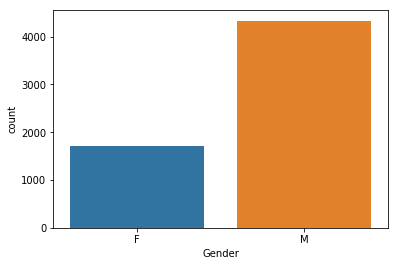

In [9]:
sns.countplot(user_df.Gender)
plt.show()

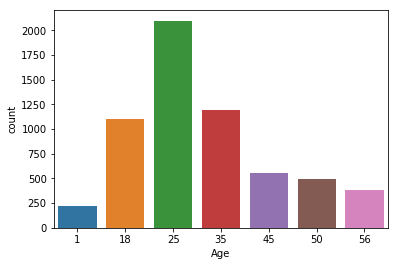

In [13]:
sns.countplot(user_df.Age)
plt.show()

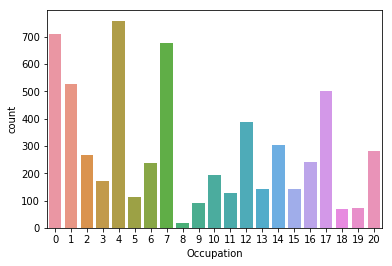

In [19]:
sns.countplot(user_df.Occupation)
plt.show()

In [17]:
user_df.zipCode.unique().shape

(3439,)

In [101]:
ratings_df = pd.read_csv('ratings.dat', sep='::', header=None, names = ['userId', 'movieId', 'rating', 'timestamp'])
ratings_df = ratings_df.merge(movie_df, how = 'left', on = 'movieId')
ratings_df = ratings_df.merge(user_df, how = 'left', on = 'userId')
ratings_df = ratings_df.drop(['userId', 'movieId', 'timestamp', 'zipCode'], axis = 1)
ratings_df

//anaconda/envs/cancer/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,rating,Year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,west,white,wild,woman,world,york,young,Gender,Age,Occupation
0,5,1975,0,0,0,0,0,0,0,1,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
1,3,1996,0,0,1,1,0,0,0,0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
2,3,1964,0,0,0,0,0,0,0,0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
3,4,2000,0,0,0,0,0,0,0,1,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
4,5,1998,0,0,1,1,1,0,0,0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
5,3,1987,1,1,0,0,1,0,0,0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
6,5,1959,1,1,0,0,0,0,0,1,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
7,5,1983,0,0,0,0,1,0,0,1,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10
8,4,1937,0,0,1,1,0,0,0,0,...,0.0,0.68559,0.0,0.0,0.0,0.0,0.0,F,1,10
9,4,1939,0,1,0,1,0,0,0,1,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,F,1,10


In [126]:
# We create the preprocessing pipelines for both numeric and categorical data.
X = ratings_df.drop('rating', axis = 1)
y = ratings_df['rating']

categorical_features = ['Occupation', 'Gender']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

numeric_features = [i for i in X.columns if i not in categorical_features]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [130]:
#Here we first try a simple linear regressor, SGDRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#('filter', SelectKBest(mutual_info_regression, k=50)
for alpha in [0.001, 0.01, 0.1, 1]:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', SGDRegressor(penalty='l2', alpha=alpha))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_pred, y_test)

    print(mae)

//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all co

0.8792388044138967


//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all co

0.8806675460518587


//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all co

0.8805563664648727


//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all co

0.8990359216604311
